Скачаем архив Alien vs. Predator, загрузим его на колаб и распакуем.

In [ ]:
!unzip -qq alien.zip

Теперь сделаем все нужные нам импорты.

In [ ]:
import os
import time
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

Датасет необходимо предобработать: превратить в тензор и обрезать до размера 224х224 (потому что наша предобученная сетка обучалась на таких картинок и ждет такого инпута). 

In [5]:
data_dir = "data"
input_shape = 224
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

#data transformation
data_transforms = {
   'train': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
   'validation': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
}

image_datasets = {
   x: datasets.ImageFolder(
       os.path.join(data_dir, x),
       transform=data_transforms[x]
   )
   for x in ['train', 'validation']
}

dataloaders = {
   x: torch.utils.data.DataLoader(
       image_datasets[x], batch_size=32,
       shuffle=True, num_workers=2
   )
   for x in ['train', 'validation']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

print(dataset_sizes)
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 694, 'validation': 200}


Посмотрим, что у нас там по данным.

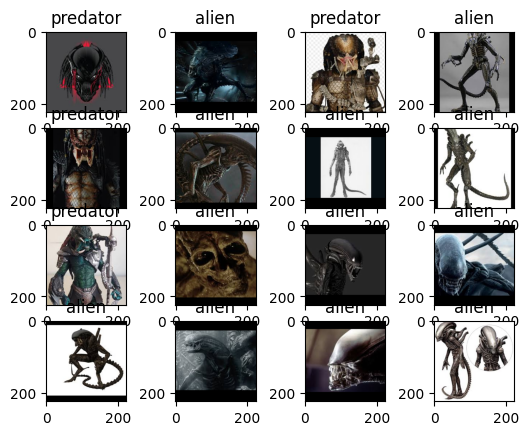

In [6]:
images, labels = next(iter(dataloaders['train']))

rows = 4
columns = 4
fig=plt.figure()
for i in range(16):
   fig.add_subplot(rows, columns, i+1)
   plt.title(class_names[labels[i]])
   img = images[i].numpy().transpose((1, 2, 0))
   img = std * img + mean
   plt.imshow(img)
plt.show()

Воспользуемся одной из готовых CNN-моделек из torchvision. Вы можете часто видеть способ загрузки pretrained=True, в последних версиях торча опять поломали всю совместимость (еще нет, но скоро да) и заменили способ загрузки на weights... любим торч нежно и неистово

In [ ]:
## Load the model based on VGG19
vgg_based = torchvision.models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1')

## freeze the layers
for param in vgg_based.parameters():
   param.requires_grad = False

# Modify the last layer
number_features = vgg_based.classifier[6].in_features
features = list(vgg_based.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, len(class_names))])
vgg_based.classifier = torch.nn.Sequential(*features)

vgg_based = vgg_based.to(device)

print(vgg_based)

criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(vgg_based.parameters(), lr=0.001, momentum=0.9)

Напишем трейнлуп.

In [8]:
def train_model(model, criterion, optimizer, num_epochs=25):
   since = time.time()

   for epoch in range(num_epochs):
       print('Epoch {}/{}'.format(epoch, num_epochs - 1))
       print('-' * 10)

       #set model to trainable
       # model.train()

       train_loss = 0

       # Iterate over data.
       for i, data in enumerate(dataloaders['train']):
           inputs , labels = data
           inputs = inputs.to(device)
           labels = labels.to(device)

           optimizer.zero_grad()

           with torch.set_grad_enabled(True):
               outputs  = model(inputs)
               loss = criterion(outputs, labels)

           loss.backward()
           optimizer.step()

           train_loss += loss.item() * inputs.size(0)

           print('{} Loss: {:.4f}'.format(
               'train', train_loss / dataset_sizes['train']))

   time_elapsed = time.time() - since
   print('Training complete in {:.0f}m {:.0f}s'.format(
       time_elapsed // 60, time_elapsed % 60))

   return model

И заодно функцию для визуализации результатов (на картинках - самая наглядная оценка)

In [ ]:
def visualize_model(model, num_images=6):
   was_training = model.training
   model.eval()
   images_so_far = 0
   fig = plt.figure()

   with torch.no_grad():
       for i, (inputs, labels) in enumerate(dataloaders['validation']):
           inputs = inputs.to(device)
           labels = labels.to(device)

           outputs = model(inputs)
           _, preds = torch.max(outputs, 1)

           for j in range(inputs.size()[0]):
               images_so_far += 1
               ax = plt.subplot(num_images//2, 2, images_so_far)
               ax.axis('off')
               ax.set_title('predicted: {} truth: {}'.format(class_names[preds[j]], class_names[labels[j]]))
               img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
               img = std * img + mean
               ax.imshow(img)

               if images_so_far == num_images:
                   model.train(mode=was_training)
                   return
       model.train(mode=was_training)

Ну и наконец поучим и посмотрим, что получилось. 

In [ ]:
vgg_based = train_model(vgg_based, criterion, optimizer_ft, num_epochs=25)

visualize_model(vgg_based)

plt.show()